# Installing Kaggle & Downloading Dataset

In [0]:
!pip -q install kaggle

In [0]:
!mkdir /root/.kaggle

In [0]:
import json
token = {"username":"raqhea","key":"6945807e6399316dfb405a62642dcd12"}
with open('/root/.kaggle/kaggle.json', 'w') as f:
  json.dump(token, f)
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 34.7MB/s]
 96% 523M/544M [00:06<00:00, 92.1MB/s]
100% 544M/544M [00:06<00:00, 92.4MB/s]
100% 270M/271M [00:04<00:00, 51.6MB/s]
100% 271M/271M [00:04<00:00, 68.6MB/s]


In [0]:
!unzip -q -o test.zip
!unzip -q -o train.zip

# Basic Preparations For Data Generators

In [0]:
!mkdir train/Cat
!mkdir train/Dog

In [0]:
!mv train/cat* train/Cat
!mv train/dog* train/Dog

# Setup

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install -q tf-nightly

     |████████████████████████████████| 521.7MB 32kB/s 
     |████████████████████████████████| 460kB 54.2MB/s 
     |████████████████████████████████| 2.9MB 56.7MB/s 


In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# additional imports for image processing, data manipulating and visualisations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os

tf.__version__

'2.2.0-dev20200507'

# Looking for corrupted images
Since we're working on JPG images, we can use JFIF encoding for corrupted images. We can use 2 methods that I found on the online:
1. Looking for JFIF encoding
2. Use pillow to verify the images

I'll use both method and find their impact on the model seperately

In [0]:
# First method

n = 0
for folder_name in ('Cat', 'Dog'):
  folder_path = os.path.join('train/', folder_name)
  for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    f_obj = open(file_path, 'rb')
    if b'JFIF' not in f_obj.peek(10):
      os.system('rm ' + file_path)
      n += 1
print('Deleted %d images' % n)

Deleted 0 images


In [0]:
# Second method

n = 0
for folder_name in ('Cat', 'Dog'):
  folder_path = os.path.join('train/', folder_name)
  for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    f_obj = open(file_path, 'rb')
    try:
      im = Image.open(file_path)
      # Use verify method to verify the images.
      im.verify()
    except:
      os.system('rm ' + file_path)
      print('Deleted : ' + file_path)
      n += 1
print('Deleted %d images' % n)

Deleted 0 images


Well, both approaches found 0 corrupted images so I believe there are no corrupted images in the dataset I use.

# Create the dataset


In [0]:
# set a constant image and batch size
image_size = (180, 180)
batch_size = 32

train_ds = keras.preprocessing.image_dataset_from_directory('train', image_size = image_size, batch_size = batch_size, 
                                                            validation_split = .2, subset = 'training', seed = 1324)
valid_ds = keras.preprocessing.image_dataset_from_directory('train', image_size = image_size, batch_size = batch_size, 
                                                            validation_split = .2, subset = 'validation', seed = 1324)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


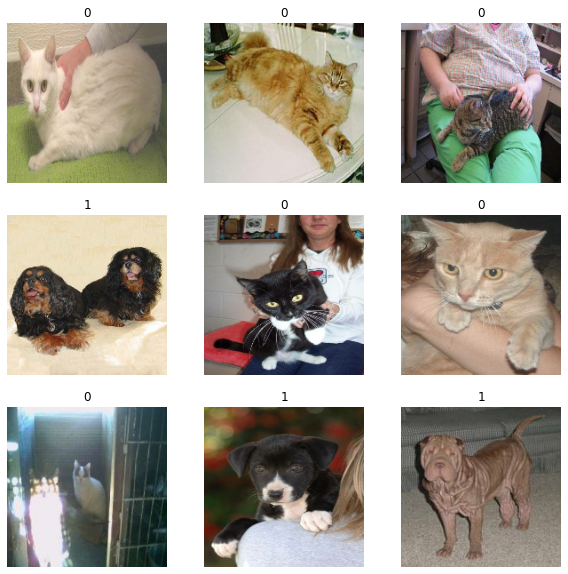

In [0]:
plt.figure(figsize = (10,10))

for images, labels in train_ds.take(1):
  for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(labels[i].numpy())
    plt.axis('off')

We can easily see that 0: Cats and 1: Dogs


# Data Augmentation
Data augmentation is the process of generating more image by using some transformations such as rotating, flipping the image etc. 
I'll use Tensorflow to create a data augmentation model and apply it to some example in order to make you understand. 

In [0]:
data_augmentation = keras.models.Sequential([
  layers.experimental.preprocessing.RandomFlip('horizontal'),
  layers.experimental.preprocessing.RandomRotation(0.1),
])

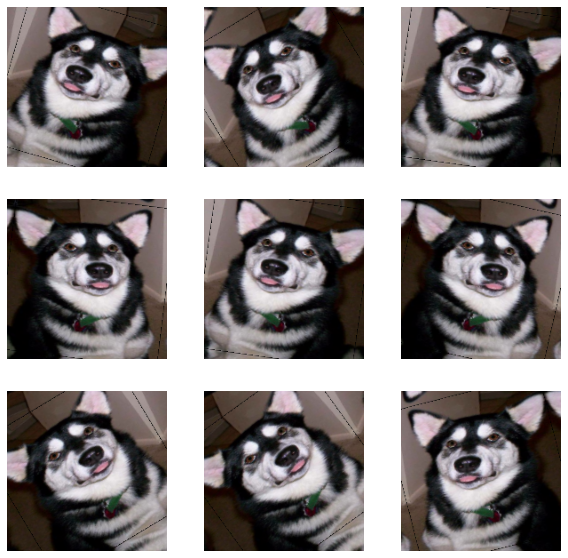

In [0]:
plt.figure(figsize = (10,10))

for images, labels in train_ds.take(1):
  for i in range(1, 10):
    augmented_ims = data_augmentation(images)
    plt.subplot(3, 3, i)
    plt.imshow(augmented_ims[0].numpy().astype('uint8'))
    plt.axis('off')

In [0]:
train_ds = train_ds.prefetch(32)
valid_ds = valid_ds.prefetch(32)

# Model creation

In [0]:
def make_model(input_shape, num_classes):
  inputs = layers.Input(shape = input_shape)
  # apply data augmentation
  x = data_augmentation(inputs)
  # apply rescaling
  x = layers.experimental.preprocessing.Rescaling(1./255)(x)

  # entry block
  x = layers.Conv2D(32, 3, strides = 2, padding = 'same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(64, 3, padding = 'same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  
  prev_act_block = x

  for size in [128, 256, 512, 728]:
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding = 'same' )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding = 'same' )(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides = 2, padding = 'same')(x)

    # add the residual
    residual = layers.Conv2D(size, 1, strides = 2, padding = 'same')(prev_act_block)
    x = layers.add([x, residual])
    prev_act_block = x
  
  x = layers.SeparableConv2D(1024, 3, padding = 'same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.GlobalAveragePooling2D()(x)

  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(1, activation = 'sigmoid')(x) # return the probabilities
  return keras.Model(inputs, outputs)

model = make_model(image_size + (3,), 2)
keras.utils.plot_model(model, show_shapes = True)

In [0]:
# epochs = 50

# model.compile(optimizer = tf.keras.optimizers.Adam(1e-3),
#               loss = 'binary_crossentropy',
#               metrics = ['accuracy'])
# r = model.fit(train_ds, validation_data = valid_ds, epochs = epochs)

# Load test dataset

In [0]:
# model.save('cats_vs_dogs_mini_xception_final.h5')
# !mv cats_vs_dogs_mini_xception_final.h5 /content/drive/"My Drive"

In [0]:
!cp /content/drive/"My Drive"/cats_vs_dogs_mini_xception_final.h5 /content/cats_vs_dogs_mini_xception_final.h5
final_model = tf.keras.models.load_model('/content/cats_vs_dogs_mini_xception_final.h5')

In [0]:
from glob import glob
def generate_img_dataset(path, image_size = (180, 180)):
  image_paths = glob(path + '/*')
  for image_path in image_paths:
    # extract image id
    # example process: 
    # train/1234.jpg => split by "/" => ['train', '1234.jpg'] => pick [-1] => ['1234.jpg'] => split by '.' => ['1234','jpg']
    #                => pick [0] => '1234' 
    img_id = image_path.split('/')[-1].split('.')[0]
    # read jpg file
    image_but_text = tf.io.read_file(image_path)
    # process image
    img = tf.image.decode_image(image_but_text, 3)
    img = tf.image.resize(img,image_size)
    yield img_id, img

In [0]:
img_generator = generate_img_dataset("test", image_size = (180, 180))
test_ds = tf.data.Dataset.from_generator(lambda: img_generator, output_types = (tf.string, tf.float32))
test_ds = test_ds.batch(32).prefetch(32)

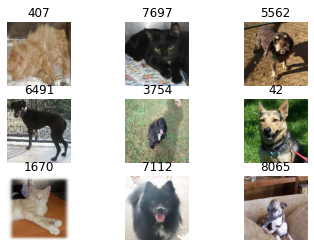

In [0]:
for ids, imgs in test_ds.take(1):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(imgs[i].numpy().astype('uint8'))
    plt.title(ids[i].numpy().decode('UTF-8'))
    plt.axis('off')

In [0]:
from datetime import datetime as dt
submission = pd.DataFrame()
c = 0
for image_ids, images in test_ds.take(-1):
    start = dt.now()
    preds = final_model.predict(images)
    df_preds = pd.DataFrame(preds, columns = ['label'])
    ids = list(map(lambda x: int(x.decode('utf-8')), image_ids.numpy()))
    df_preds['id'] = ids
    df_preds = df_preds.reindex(['id', 'label'], axis = 1)
    submission = pd.concat((submission, df_preds))
    final = dt.now()
    c += len(images)
    print('\n Processed {} images in {}'.format(32, final-start))
    print(f'\n Processed {c} images in total\n' + "-"*30 )
submission.sort_values(by='id', inplace=True)
submission.describe()


 Processed 32 images in 0:00:00.097506

 Processed 32 images in total
------------------------------

 Processed 32 images in 0:00:00.097766

 Processed 64 images in total
------------------------------

 Processed 32 images in 0:00:00.095215

 Processed 96 images in total
------------------------------

 Processed 32 images in 0:00:00.098543

 Processed 128 images in total
------------------------------

 Processed 32 images in 0:00:00.100344

 Processed 160 images in total
------------------------------

 Processed 32 images in 0:00:00.097967

 Processed 192 images in total
------------------------------

 Processed 32 images in 0:00:00.103370

 Processed 224 images in total
------------------------------

 Processed 32 images in 0:00:00.109829

 Processed 256 images in total
------------------------------

 Processed 32 images in 0:00:00.100393

 Processed 288 images in total
------------------------------

 Processed 32 images in 0:00:00.096130

 Processed 320 images in total
----

,id,label
count,12500.000000,1.250000e+04
mean,6250.500000,4.535803e-01
std,3608.583517,4.801595e-01
min,1.000000,8.311457e-28
25%,3125.750000,6.208840e-11
50%,6250.500000,5.404732e-02
75%,9375.250000,9.998873e-01
max,12500.000000,1.000000e+00


In [0]:
submission.to_csv('submission.csv', index = False)

In [0]:
!kaggle competitions submit dogs-vs-cats-redux-kernels-edition -f submission.csv -m "full tensorflow2 automated work-flow"
!kaggle competitions submissions dogs-vs-cats-redux-kernels-edition

100% 202k/202k [00:03<00:00, 65.3kB/s]
Successfully submitted to Dogs vs. Cats Redux: Kernels EditionWarning: Looks like you're using an outdated API Version, please consider updating (server 1.5.6 / client 1.5.4)
fileName        date                 description                           status    publicScore  privateScore  
--------------  -------------------  ------------------------------------  --------  -----------  ------------  
submission.csv  2020-05-07 23:08:40  full tensorflow2 automated work-flow  complete  0.25491      0.25491       
submission.csv  2020-05-07 22:56:37  full tensorflow2 automated work-flow  complete  0.25491      0.25491       
submission.csv  2020-05-07 22:51:01  full tensorflow2 automated work-flow  complete  0.25491      0.25491       
